## Analyze FK8 DMS data in WT, Hel2-del and Upf1-del cells

In [1]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(plotrix))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


### Global themes

In [2]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [3]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

### Load sample annotations and counts from manuscript

In [4]:
sample_annotations_mn <- read_csv("../../wt_hel2_fk8_dms/annotations/sample_annotations.csv", comment='#')

Rows: 8 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (6): insert_read, insert_start, insert_length, umi_read, umi_start, umi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
spikein_annotations_mn <- read_csv("../../wt_hel2_fk8_dms/annotations/insert_annotations.csv", show_col_types = F) %>%
    filter(is.na(codon)) %>%
    select(insert_num, insert_seq, wt_motif, motif, mutstart, codon) %>%
    mutate(aa = 'spikein', motif = 'SPIKEIN')

In [6]:
variant_annotations_mn <- read_csv("../../wt_hel2_fk8_dms/annotations/insert_annotations.csv", show_col_types = F) %>%
    drop_na() %>%
    mutate(wt_seq = 'TTCAAGTTTAAGTTCAAGTTCAAATTCAAGTTTAAGTTCAAGTTCAAA') %>%
    mutate(aa = as.character(translate(DNAStringSet(codon), no.init.codon = T))) %>%
    mutate(aa_loc = (mutstart+2)/3) %>%
    mutate(wt_codon = substr(wt_seq, mutstart, mutstart+2)) %>%
    mutate(wt_aa = as.character(translate(DNAStringSet(wt_codon), no.init.codon = T))) %>% 
    group_by(insert_seq) %>%
    slice(1) %>% # removes repeated WT sequences
    ungroup() %>%
    select(insert_num, insert_seq, wt_motif, motif, mutstart, codon, aa, aa_loc, wt_codon, wt_aa) %>%
    bind_rows(spikein_annotations_mn)

### Read in raw variant counts from manuscript experiment

In [7]:
raw_counts_mn <- list.files("../../wt_hel2_fk8_dms/data/annotated_insert_umi_counts", full.names = T, pattern = "csv$") %>%
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(sample_name, -file, data) %>%
  unnest(data)

In [8]:
variant_counts_mn <- raw_counts_mn %>%
    mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
    inner_join(variant_annotations_mn, by = c("insert_num"))

In [9]:
seq_effect_mn <- variant_counts_mn %>%
    group_by(sample_name, insert_num) %>%
    summarize(read_count = sum(count), umi_count = n(), .groups='drop') %>%
    left_join(select(sample_annotations_mn, sample_id, sample_name), by=c('sample_name')) %>%
    mutate(sample_type = str_extract(sample_name, "rna|grna"), 
            replicate = str_extract(sample_name, "1$|2$")) %>%
    mutate(replicate = ifelse(is.na(replicate), '1', replicate)) %>%
    mutate(genotype = str_extract(sample_name, "[^_]+"))

In [10]:
umi_count_lfc_mn <- seq_effect_mn %>%
  select(-sample_id, -sample_name, -read_count) %>%
  pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
  filter(!is.na(grna_1), !is.na(grna_2), !is.na(rna_1), !is.na(rna_2)) %>% 
  mutate(lfc_1 = log2(rna_1/grna_1), lfc_2 = log2(rna_2/grna_2))

In [11]:
sc_umi_lfc_mn <- seq_effect_mn %>% # repeat above for spikein counts
  select(-sample_id, -sample_name, -read_count) %>%
  left_join(variant_annotations_mn, by='insert_num') %>%
  filter(motif == 'SPIKEIN') %>%
  group_by(genotype, motif, replicate, sample_type) %>%
  summarize(umi_count = sum(umi_count), .groups='drop') %>%
  pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
  mutate(lfc_1 = log2(rna_1/grna_1), lfc_2 = log2(rna_2/grna_2)) %>%
  mutate(lfc = mean(c(lfc_1,lfc_2)), lfc_diff = abs(lfc_1 - lfc_2))

In [12]:
lfc_umi_sc_mn <- umi_count_lfc_mn %>% 
    left_join(variant_annotations_mn, by='insert_num') %>%
    filter(motif != 'SPIKEIN') %>%
    group_by(genotype, insert_num) %>%
    mutate(lfc = mean(c(lfc_1,lfc_2)), lfc_diff = abs(lfc_1 - lfc_2)) %>%
    ungroup() %>%
    mutate(wt = (aa == wt_aa)) %>%
    bind_rows(sc_umi_lfc_mn) %>%
    select(insert_num, genotype, insert_seq, motif, mutstart, codon, aa, aa_loc, wt_codon, wt_aa, wt, lfc_1, lfc_2, lfc) %>%
    group_by(genotype) %>%
    mutate(lfc_sc_1 = lfc_1 - lfc[motif == 'SPIKEIN']) %>% # normalize inserts to spikein umi for rep1
    mutate(lfc_sc_2 = lfc_2 - lfc[motif == 'SPIKEIN']) %>% # and rep2
    mutate(lfc_sc = lfc - lfc[motif == 'SPIKEIN']) %>% # and for the avg of rep1 and rep2
    ungroup() %>%
    select(-lfc_1, -lfc_2)

### Load annotations/counts for revision *upf1∆* data

In [16]:
sample_annotations <- read_csv("../annotations/sample_annotations.csv", comment='#')

Rows: 8 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): owner, sample_name, library_type, illumina_sample_id, sample_id, r1...
dbl (6): insert_read, insert_start, insert_length, umi_read, umi_start, umi_...
lgl (2): s3, shared

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
wt_seqs <- read_csv('../annotations/motifs_for_dms.csv') %>% 
    filter(name == 'fk8')

Rows: 2 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): name, aa, nt

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 3 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): pair, insert
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
variant_annotations <- read_csv("../annotations/insert_annotations.csv", show_col_types = F) %>%
    mutate(insert_seq = as.character(reverseComplement(DNAStringSet(insert_seq)))) %>%
    mutate(aa = as.character(translate(DNAStringSet(codon), no.init.codon = T))) %>%
    mutate(aa_loc = (mutstart+2)/3) %>%
    left_join(wt_seqs, by=c('id'='name', 'wt_motif'='aa')) %>%
    dplyr::rename(wt_seq=nt) %>%
    mutate(wt_codon = substr(wt_seq, mutstart, mutstart+2)) %>%
    mutate(wt_aa = as.character(translate(DNAStringSet(wt_codon), no.init.codon = T))) %>% 
    group_by(insert_seq) %>%
    slice(1) %>% # removes repeated WT sequences
    ungroup() %>%
    select(insert_num, id, insert_seq, wt_motif, motif, mutstart, codon, aa, aa_loc, wt_codon, wt_aa, wt_seq)  %>%
    add_row(insert_num = 1025, id = 'spikein', motif = 'SPIKEIN')

In [19]:
sc_annotations <- read_csv("../annotations/spikein_annotations.csv")

Rows: 2 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): insert_seq, id, motif, wt_motif
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
sc_counts <- list.files("../data/annotated_insert_umi_counts_sc", full.names = T, pattern = "csv$") %>% 
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(sample_name, -file, data) %>%
  unnest(data) %>%
  group_by(sample_name, insert_num) %>%
  summarize(read_count = sum(count), umi_count = n()) %>%
  left_join(sc_annotations, by='insert_num') %>%
  select(sample_name, umi_count, id) %>%
  pivot_wider(names_from=id, values_from=c(umi_count))

`summarise()` has grouped output by 'sample_name'. You can override using the
`.groups` argument.


In [21]:
sc_umi_avg <- sc_counts %>%
    mutate(avg = (spikein2 + spikein5)/2) %>%
    separate(sample_name, c('genotype', 'x', 'y', 'replicate', 'type')) %>%
    select(-spikein2, -spikein5, -x, -y) %>%
    mutate(replicate = str_extract(replicate, "[12]")) %>%
    pivot_wider(names_from=c(type, replicate), values_from=avg) %>%
    mutate(insert_num = 4097) %>%
    mutate(lfc_1 = log2(mrna_1/gdna_1), lfc_2 = log2(mrna_2/gdna_2))

In [22]:
raw_counts <- list.files("../data/annotated_insert_umi_counts", full.names = T, pattern = "csv$") %>%
  as_tibble_col("file") %>%
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>%
  mutate(data = map(file, . %>% read_csv(show_col_types = F))) %>%
  select(sample_name, -file, data) %>%
  unnest(data)

In [23]:
variant_counts <- raw_counts %>%
    inner_join(variant_annotations, by = c("insert_num"))

In [24]:
seq_effect_2 <- variant_counts %>%
    group_by(sample_name, insert_num) %>%
    summarize(read_count = sum(count), umi_count = n(), .groups='drop') %>%
    left_join(select(sample_annotations, sample_id, sample_name), by=c('sample_name')) %>%
    mutate(sample_type = str_extract(sample_name, "mrna|gdna"), 
            replicate = str_extract(sample_name, "(?<=_rep)[12](?=_)")) %>%
    mutate(genotype = str_extract(sample_name, "[^_]+"))

## Join all replicates (manuscript + recent run) together

In [25]:
combined_sc_lfc <- seq_effect_2 %>%
    select(-sample_id, -sample_name, -read_count) %>%
    pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
    mutate(lfc_1 = log2(mrna_1/gdna_1), lfc_2 = log2(mrna_2/gdna_2)) %>%
    bind_rows(sc_umi_avg) %>%
    group_by(genotype) %>%
    mutate(lfc_sc_1 = lfc_1 - lfc_1[insert_num == 1025]) %>% # normalize insert lfcs to spikein lfc for rep1
    mutate(lfc_sc_2 = lfc_2 - lfc_2[insert_num == 1026]) %>% # and rep2
    ungroup() %>%
    left_join(variant_annotations, by='insert_num') %>%
    filter(id == 'fk8') %>%
    select(-insert_num, -insert_seq, -wt_motif, -wt_seq, -gdna_1, -mrna_1, -gdna_2, -mrna_2, -lfc_1, -lfc_2, -id) %>%
    mutate(wt = (aa == wt_aa)) %>%
    bind_rows(lfc_umi_sc_mn) %>% # combine with spike-in normalized manuscript data
    select(-insert_seq, -lfc, -insert_num, -lfc_sc) %>%
    filter(motif != 'SPIKEIN')

In [30]:
combined_sc_lfc_no_wt <- seq_effect_2 %>%
    select(-sample_id, -sample_name, -read_count) %>%
    pivot_wider(names_from = c("sample_type", "replicate"), values_from = c("umi_count")) %>%
    mutate(lfc_1 = log2(mrna_1/gdna_1), lfc_2 = log2(mrna_2/gdna_2)) %>%
    bind_rows(sc_umi_avg) %>%
    group_by(genotype) %>%
    mutate(lfc_sc_1 = lfc_1 - lfc_1[insert_num == 4097]) %>% # normalize insert lfcs to spikein lfc for rep1
    mutate(lfc_sc_2 = lfc_2 - lfc_2[insert_num == 4097]) %>% # and rep2
    ungroup() %>%
    left_join(variant_annotations, by='insert_num') %>%
    filter(id == 'fk8') %>%
    select(-insert_num, -insert_seq, -wt_motif, -wt_seq, -gdna_1, -mrna_1, -gdna_2, -mrna_2, -lfc_1, -lfc_2, -id) %>%
    mutate(wt = (aa == wt_aa)) %>%
    bind_rows(lfc_umi_sc_mn) %>% # combine with spike-in normalized manuscript data
    select(-insert_seq, -lfc, -insert_num, -lfc_sc) %>%
    filter(motif != 'SPIKEIN') %>%
    mutate(lfc_sc = case_when( !(is.na(lfc_sc_1)) & !(is.na(lfc_sc_2)) ~ (lfc_sc_1 + lfc_sc_2)/2,
                          !(is.na(lfc_sc_1)) & is.na(lfc_sc_2) ~ lfc_sc_1,
                          is.na(lfc_sc_1) & !(is.na(lfc_sc_2)) ~ lfc_sc_2,
                          )) %>% # some replicates are missing, so keep whichever is available or take the average if both are available
    select(-lfc_sc_1, -lfc_sc_2) %>%
    drop_na(lfc_sc)

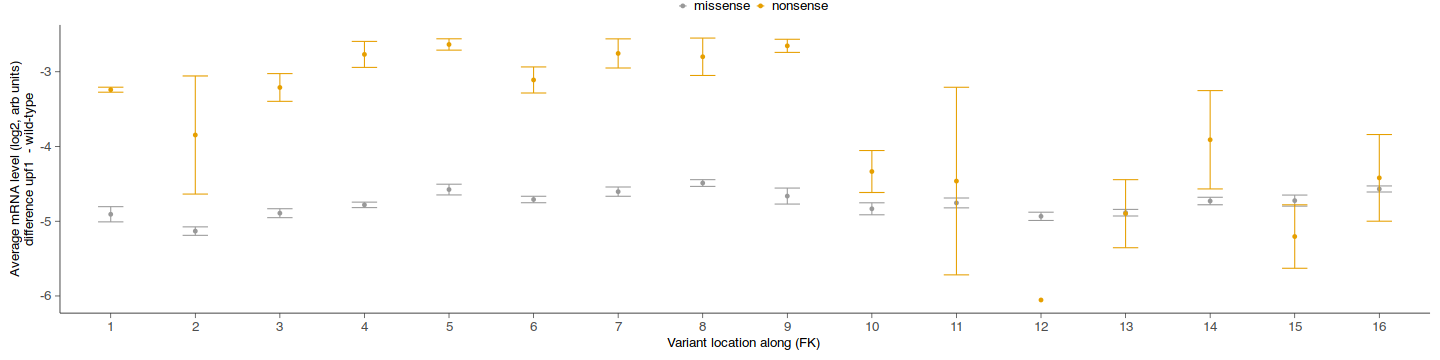

In [48]:
combined_sc_lfc_no_wt %>%
    filter(genotype != 'hel2') %>%
    select(-motif, -wt) %>%
    pivot_wider(names_from=genotype, values_from=lfc_sc) %>%
    mutate(diff = upf1 - wt) %>%
    mutate(wt = (aa == wt_aa)) %>%
    filter(wt != TRUE) %>%
    mutate(stop = ifelse(aa == '*', 'nonsense', 'missense')) %>%
    drop_na(diff) %>%
    group_by(aa_loc, stop) %>%
    summarize(avg_diff = mean(diff), se = std.error(diff), .groups='drop') %>%
    ggplot() +
    aes(x=as.factor(aa_loc), y=avg_diff, ymin=avg_diff-se, ymax=avg_diff+se, color=stop) +
    geom_point(size=0.7) +
    geom_errorbar(size=0.3, width=0.3) +
    theme +
    theme(legend.position = "top",
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
    labs(y='Average mRNA level (log2, arb units)\ndifference upf1  - wild-type', x='Variant location along (FK) ', color='')

ggsave("../figures/upf1_wt_diff_per_loc_no_med_norm.pdf", width=3.5, height=1.8)

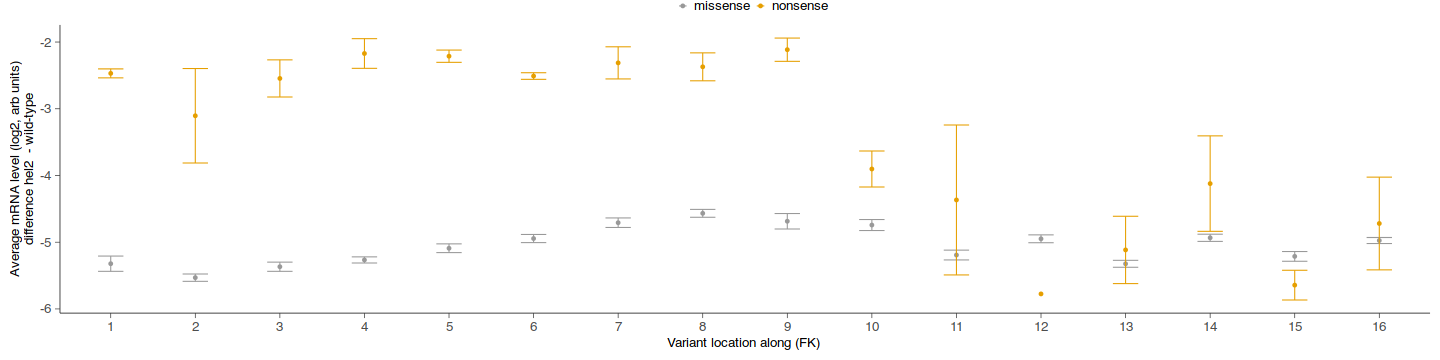

In [47]:
combined_sc_lfc_no_wt %>%
    filter(genotype != 'wt') %>%
    select(-motif, -wt) %>%
    pivot_wider(names_from=genotype, values_from=lfc_sc) %>%
    mutate(diff = upf1 - hel2) %>%
    mutate(wt = (aa == wt_aa)) %>%
    filter(wt != TRUE) %>%
    mutate(stop = ifelse(aa == '*', 'nonsense', 'missense')) %>%
    drop_na(diff) %>%
    group_by(aa_loc, stop) %>%
    summarize(avg_diff = mean(diff), se = std.error(diff), .groups='drop') %>%
    ggplot() +
    aes(x=as.factor(aa_loc), y=avg_diff, ymin=avg_diff-se, ymax=avg_diff+se, color=stop) +
    geom_point(size=0.7) +
    geom_errorbar(size=0.3, width=0.3) +
    theme +
    theme(legend.position = "top",
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
    labs(y='Average mRNA level (log2, arb units)\ndifference hel2  - wild-type', x='Variant location along (FK) ', color='')

ggsave("../figures/upf1_hel2_diff_per_loc_no_med_norm.pdf", width=3.5, height=1.8)